# Fit exponentials to Cell 5 from Kylie

All the data files are in my OneDrive at: /OneDrive .../Postdoc/cardiacNoiseData, but I'll add some of the data here in folder Some_Kilies_data/
There is a readme.txt file explaining what is in each file, including the names of the protocols and a dictionary of cell's names.  Protocols 3-5 are big files to have in github. Protocl 7 is the sine wave data, and protocol 6 is the action potential data. I'll start with one of the smaller data sets.

The protocols that I have the myokit version are 2, 3, 4, 5

To do:
- Code an exponential approximation <- DONE
- load data
- minimize residuals



In [1]:
# Libraries
import matplotlib.pyplot as plt
import numpy as np
import myokit
import myokit.lib.markov
#from scipy.interpolate import interp1d,  UnivariateSpline, splrep, splev, make_lsq_spline, BSpline
from scipy.optimize import minimize#, curve_fit
import cma

In [2]:
def SRexpo_spline(params, times,deltat,data):#datafull):
    #times = datafull[0]
    #data = datafull[1]
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    residuals = expo_splines - data
    return sum(residuals**2)

def expo_spline(times,deltat,params):
    expo_splines = params[0] + params[1]*np.exp(-(times-deltat)/params[2])+params[3]*np.exp(-(times-deltat)/params[4])
    return expo_splines

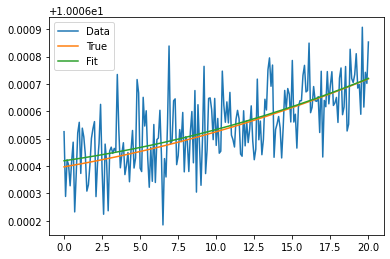

[ 1.00020362e+01  1.26127949e-03  1.31303686e+02  9.23540619e-03
 -5.87143984e+01]
[ 1.e+01  1.e-03  1.e+02  1.e-02 -1.e+02]


In [3]:
tmax = 20
dt = .1
deltat = 100
times = np.arange(0, tmax+dt, dt)
params = np.array([10,.001,100,.01,-100])
epsi = 0.0001*np.random.randn(len(times))


x =  expo_spline(times,deltat,params)+ epsi
y = SRexpo_spline(params, times,deltat,x)


res = minimize(SRexpo_spline, params,args = (times,deltat, x), method='Nelder-Mead', tol=1e-6)

params_res = res.x
z =  expo_spline(times,deltat,params_res)


plt.plot(times,x, label = 'Data')
plt.plot(times,x-epsi, label = 'True' )
plt.plot(times,z, label = 'Fit')
plt.legend()
plt.show()

print(params_res)
print(params)


(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=1036207, Thu Jun 17 21:57:20 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.656318032969314e+02 1.0e+00 9.31e-01  9e-01  1e+00 0:00.0
    2     16 3.198614149278763e+00 1.3e+00 8.12e-01  7e-01  9e-01 0:00.0
    3     24 7.290926665289458e+00 1.3e+00 9.96e-01  8e-01  1e+00 0:00.0
  100    800 3.765366610144669e-06 5.3e+03 5.56e-02  5e-03  2e-01 0:00.2
  181   1448 2.219952002610976e-06 4.7e+05 6.81e-04  3e-06  5e-03 0:00.3
termination on tolfun=1e-11 (Thu Jun 17 21:57:23 2021)
final/bestever f-value = 2.219952e-06 2.219952e-06
incumbent solution: [9.999456560336913, 0.0011088751205020205, 99.66154161941976, 0.010464288610436101, -102.30939382884426]
std deviation: [1.7324193221688628e-05, 3.4588626459325028e-06, 0.00513250157201458, 2.1076687376263767e-05, 0.002523686411067747]


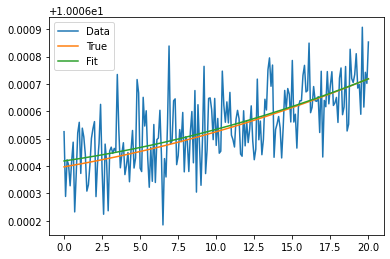

[ 9.99945656e+00  1.10887512e-03  9.96615416e+01  1.04642886e-02
 -1.02309394e+02]
2.2199519729767588e-06


In [4]:
# testing CMA
p0 = params # [0,1,1,.5,1]
es = cma.fmin(SRexpo_spline, params , sigma0=1, args=[times,deltat,x])

params_cma = es[0]
score_cma = es[1]


plt.plot(times,x, label = 'Data')
plt.plot(times,x-epsi, label = 'True' )
plt.plot(times,expo_spline(times,deltat,params_cma), label = 'Fit')
plt.legend()
plt.show()

print(params_cma)
print(score_cma)

## Focus on one protocol first

Start with protocol 3, cell 5

To do:
- divide wrt constant V intervals
- investigate the spline interpolation
- get splines per interval
- get residuals
- ploy residuals vs 1. Current, 2. Voltage, 3. time

In [5]:
# Load the data
pr3_time, pr3_voltage, pr3_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR3cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)

# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov.mmt')
# Load a protocols
protocol_3 = myokit.load_protocol('resources/pr3-steady-activation.mmt')


# Define the steps of the protocol
pr3_Vtimes = (np.array(protocol_3.log_for_interval(0,pr3_time[-1] + 0.1)['time'])*10)
pr3_Vtimes = pr3_Vtimes.astype(np.int32)

pr3_current_constV = {}
for i in range(len(pr3_Vtimes)-1):
    pr3_current_constV[i]= pr3_current[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)]


print(len(pr3_current_constV))



42


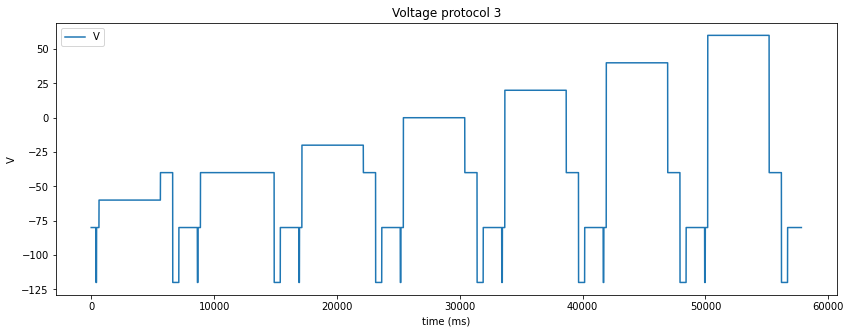

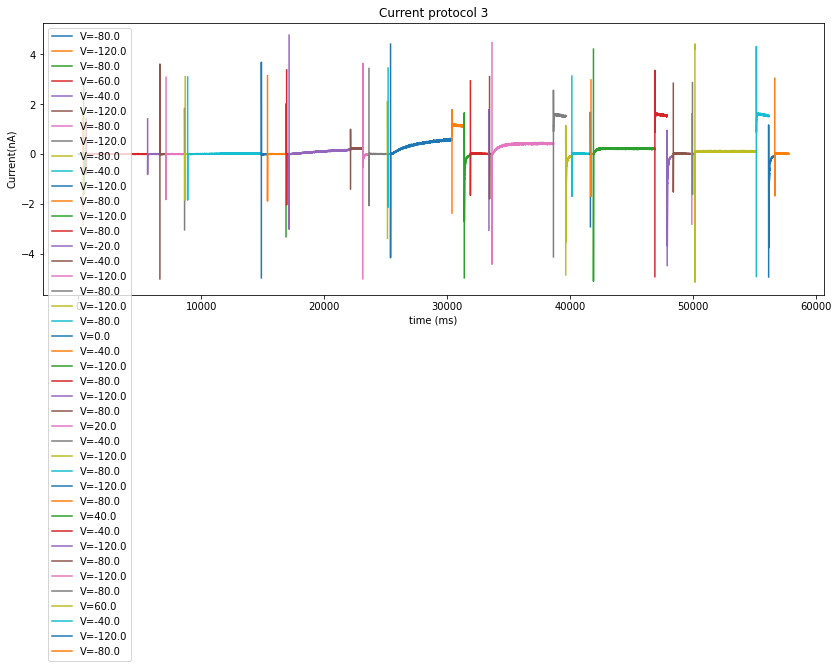

In [6]:
plt.figure(figsize=(14, 5))
plt.plot(pr3_time, pr3_voltage,'-', label='V')
plt.xlabel('time (ms)')
plt.ylabel('V')
plt.title('Voltage protocol 3')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(14, 5))
for i in range(len(pr3_Vtimes)-1):
    plt.plot(pr3_time[pr3_Vtimes[i]:(pr3_Vtimes[i+1]-1)], pr3_current_constV[i],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))

plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3')
plt.legend(loc='upper left')
plt.show()



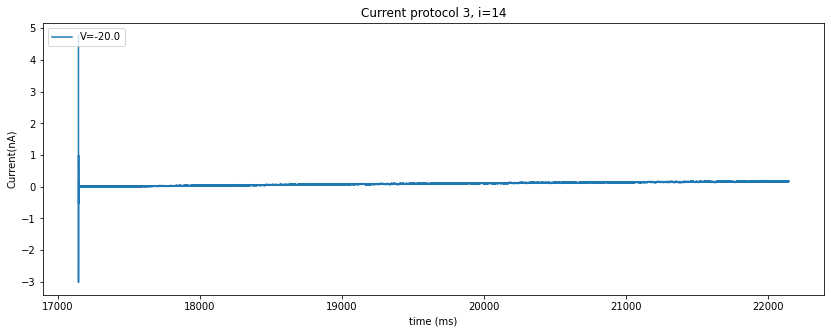

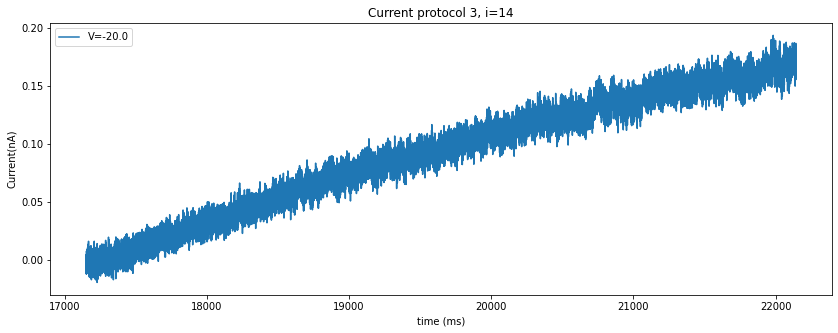

In [10]:
i=14

plt.figure(figsize=(14, 5))
plt.plot(pr3_time[(pr3_Vtimes[i]):(pr3_Vtimes[i+1]-1)], pr3_current_constV[i],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, i='+str(i))
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(pr3_time[(pr3_Vtimes[i]+50):(pr3_Vtimes[i+1]-1)], pr3_current_constV[i][50:],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, i='+str(i))
plt.legend(loc='upper left')
plt.show()

17150.1
(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 5 (seed=1094820, Thu Jun 17 22:09:20 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 3.038859951297565e+06 1.0e+00 1.04e+00  9e-01  1e+00 0:00.1
    2     16 1.630881987446777e+04 1.4e+00 1.12e+00  9e-01  2e+00 0:00.1
    3     24 2.429376858330579e+05 1.8e+00 1.09e+00  8e-01  1e+00 0:00.1
   72    576 7.829727723421937e+00 2.8e+02 1.38e-02  9e-05  1e-02 0:03.2
  100    800 7.706490558607530e+00 7.1e+02 7.16e-04  1e-06  5e-04 0:04.3
NOTE (module=cma, iteration=150):  
condition in coordinate system exceeded 1.1e+08, rescaled to 1.0e+00, 
condition changed from 2.5e+08 to 2.4e+02
  200   1600 7.372754592486347e+00 1.8e+02 6.53e-01  5e-05  1e+01 0:08.3
  300   2400 5.406324939220593e+00 1.8e+03 1.63e+00  6e-06  2e+01 0:12.0
  400   3200 4.743625838384032e+00 3.3e+04 1.31e+00  7e-08  5e+00 0:15.8
NOTE (module=cma, iteration=413):  
condition in coordinate system exceeded 1.0e+08, rescaled to

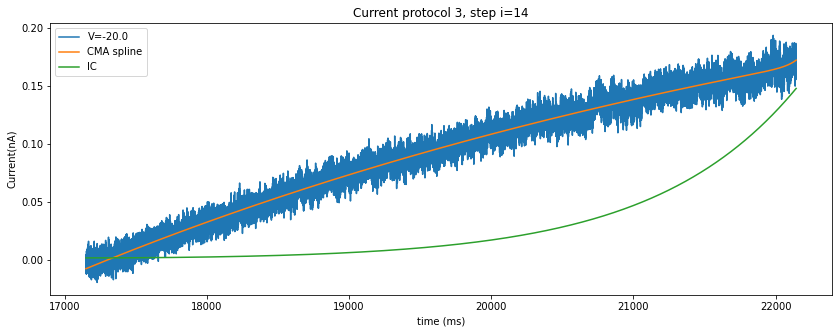

In [34]:
# Find the exponentials usin CMA
times = pr3_time[(pr3_Vtimes[i]+50):(pr3_Vtimes[i+1]-1)]
data = pr3_current_constV[i][50:]
deltat = times[0]
print(deltat)

# Let's try with CMA
p0 = [0,.001,1000,.001,-1000]

es = cma.fmin(SRexpo_spline, p0 , sigma0=1, args=[times, deltat, data])
params_cma = es[0]
score_cma = es[1]
cma_expo_fit = expo_spline(times, deltat, params_cma)

plt.figure(figsize=(14, 5))
plt.plot(times, pr3_current_constV[i][50:],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.plot(times, cma_expo_fit, label = 'CMA spline')
plt.plot(times, expo_spline(times, deltat, p0), label = 'IC')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, step i='+str(i))
plt.legend(loc='upper left')


plt.show()

E((X-mu)^2)= Np(1-p)i^2 = mu*i - mu^2/N
mu= Npi


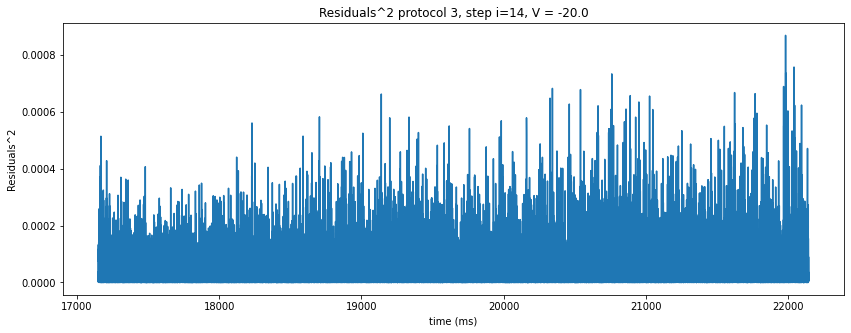

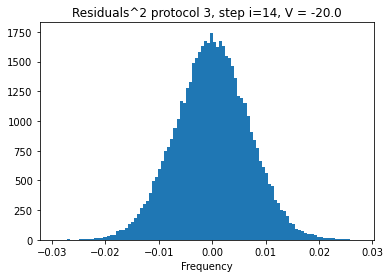

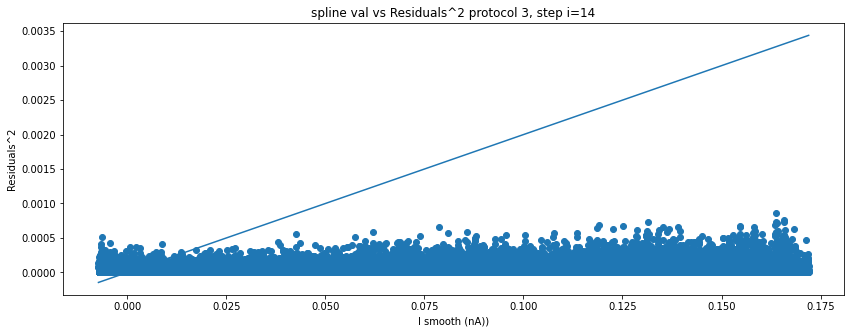

In [40]:
residuals = cma_expo_fit - data

plt.figure(figsize=(14, 5))
#plt.plot(times, pr3_current_constV[i][50:],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.plot(times, residuals**2)
#plt.plot(times, splev(times, spl2), label = 'Spline2')
plt.xlabel('time (ms)')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]))


plt.figure()
plt.hist(residuals, bins = 100)
plt.xlabel('Residuals^2')
plt.xlabel('Frequency')
plt.title('Residuals^2 protocol 3, step i=' + str(i) + ', V = '+ str(pr3_voltage[pr3_Vtimes[i]]))




N=76000
indv_current = 0.02 # gamma = i/(E_com - E_rev)
print("E((X-mu)^2)= Np(1-p)i^2 = mu*i - mu^2/N")
print("mu= Npi")

plt.figure(figsize=(14, 5))
#plt.plot(times, pr3_current_constV[i][50:],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.scatter(cma_expo_fit, residuals**2)
plt.plot(cma_expo_fit, cma_expo_fit * (indv_current - cma_expo_fit/N))
#plt.plot(times, splev(times, spl2), label = 'Spline2')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.title('spline val vs Residuals^2 protocol 3, step i='+str(i))

plt.show()

In [ ]:
i=20

plt.figure(figsize=(14, 5))
plt.plot(pr3_time[(pr3_Vtimes[i]):(pr3_Vtimes[i+1]-1)], pr3_current_constV[i],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(pr3_time[(pr3_Vtimes[i]+30):(pr3_Vtimes[i+1]-1)], pr3_current_constV[i][30:],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3')
plt.legend(loc='upper left')
plt.show()

In [ ]:
times = pr3_time[(pr3_Vtimes[i]+50):(pr3_Vtimes[i+1]-1)]
spl2 = UnivariateSpline(times, pr3_current_constV[i][50:], k=5)

residuals = spl2(times) - pr3_current_constV[i][50:]


plt.figure(figsize=(14, 5))
plt.plot(times, pr3_current_constV[i][50:],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.plot(times, spl2(times), label = 'Spline')
#plt.plot(times, splev(times, spl2), label = 'Spline2')
plt.xlabel('time (ms)')
plt.ylabel('Current(nA)')
plt.title('Current protocol 3, step i='+str(i))
plt.legend(loc='upper left')


plt.figure(figsize=(14, 5))
#plt.plot(times, pr3_current_constV[i][50:],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.plot(times, residuals**2)
#plt.plot(times, splev(times, spl2), label = 'Spline2')
plt.xlabel('time (ms)')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 protocol 3, step i='+str(i))


plt.figure()
plt.hist(residuals, bins = 100)


plt.show()

In [ ]:
plt.figure(figsize=(14, 5))
#plt.plot(times, pr3_current_constV[i][50:],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.scatter(times, residuals_savgol**2)
#plt.plot(times, splev(times, spl2), label = 'Spline2')
plt.xlabel('time (ms)')
plt.ylabel('Residuals^2')
plt.title('Residuals^2 protocol 3, step i='+str(i))



plt.figure(figsize=(14, 5))
#plt.plot(times, pr3_current_constV[i][50:],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.scatter(spl_savgol, residuals_savgol**2)
#plt.plot(spl_savgol,spl_savgol*(1-spl_savgol/1000))
#plt.plot(times, splev(times, spl2), label = 'Spline2')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.title('spline val vs Residuals^2 protocol 3, step i='+str(i))

plt.show()

In [ ]:
N=76000
indv_current = 
print("E((X-mu)^2)= Np(1-p)i")
print("mu= Npi")

plt.figure(figsize=(14, 5))
#plt.plot(times, pr3_current_constV[i][50:],'-', label='V='+str(pr3_voltage[pr3_Vtimes[i]]))
plt.scatter(spl_savgol, residuals_savgol**2)
plt.plot(spl_savgol,spl_savgol*(indv_current-spl_savgol/N))
#plt.plot(times, splev(times, spl2), label = 'Spline2')
plt.xlabel('I smooth (nA))')
plt.ylabel('Residuals^2')
plt.title('spline val vs Residuals^2 protocol 3, step i='+str(i))

plt.show()

## Rest of the protocols

In [ ]:
# Import the data
pr2_time, pr2_voltage, pr2_current = np.loadtxt('Some_Kylies_data/KyliePR2cell123456910.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr3_time, pr3_voltage, pr3_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR3cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr4_time, pr4_voltage, pr4_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/cardiac_noise/KylieData/KyliePR4cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)
pr5_time, pr5_voltage, pr5_current = np.loadtxt('/Users/pmzah/OneDrive - The University of Nottingham/Postdoc/cardiacNoiseData/KyliePR5cellall.txt', delimiter=',',skiprows=1, usecols=(0,1,6), unpack=True)



# Load model
model = myokit.load_model('resources/beattie-2017-ikr-markov.mmt')
# Load a protocols
protocol_2 = myokit.load_protocol('resources/pr2-activation-kinetics-2.mmt')
protocol_3 = myokit.load_protocol('resources/pr3-steady-activation.mmt')
protocol_4 = myokit.load_protocol('resources/pr4-inactivation.mmt')
protocol_5 = myokit.load_protocol('resources/pr5-deactivation.mmt')


plt.figure(figsize=(15,4))
plt.title('Cell 5 currents ')
plt.plot(pr2_time, pr2_current, label='Pr2')
plt.plot(pr3_time, pr3_current, label='Pr3')
plt.plot(pr4_time, pr4_current, label='Pr4')
plt.plot(pr5_time, pr5_current, label='Pr5')
plt.xlabel('time (ms)')
plt.ylabel('I (nA)')
plt.legend()


plt.show()
